## GPT detection project

Information about the project and types of features aggregated to make predictions.

This project aims to detect texts generated by chatGPT(3.5) as opposed to texts written by humans. To do this we will train a random forest model on 3 groups of features, and will as well compare performance on the full set of features. We hypothesize that groups of features described below will allow for reasonable division of chatGPT and human written essays.

1. general text features - these focus on lengths of texts, paragraphs and sentences. These features inform us about the basic complexity of text (simple vs. complex sentences) as well as the propensity to write shorter or longer texts on average.

2. stylistic features - quantifiable features that are mostly focused on the uniquness of text. Therefore, we measure numbers of unique words, repetitions, words that belong to certain categories (such as discourse markers, stopwords or pronouns) as well as sentiment and readability.

3. punctuation - two features - punctuation count and punctuation errors - are supposed to measure the propensity to use punctuation and measure whether it's used correctly.



The project is structured as follows:

1. low level functions to be used later on "text", "paragraphs" and "sentences" columns.

2. Low level functions are aggregated for convenience in bigger functions that enable the user to get all features for the "text", "paragraphs" or "sentences" at once. These tools are not very computationally intensive, which means that you can make those calls on big amounts of data as well.

3. Resulting dataframe is split according to aforementioned features in order to run separate models and test features utility. For this purpose, the notebook is divided into specific sections.

4. Each section displays important metrics for features of the model.

5. Final tables summarize performance on separate groups of features and the whole data.

In [1]:
import numpy as np
import pandas as pd

import string
import re

import language_tool_python
from textblob import TextBlob
from collections import Counter
from textstat import flesch_reading_ease, flesch_kincaid_grade

from nltk import sent_tokenize, word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

## Project functions

In [2]:
# Defining subfunctions to be used with other functions

# Tokenizing words (nltk tokenizer) and removing tokens that contain punctuation, like "."
def tokenize_and_remove(text):
    
    tokenized_text = word_tokenize(text)
    words = list(filter(lambda token: token not in string.punctuation, tokenized_text))
    
    return words

# Counting words - a single paragraph should be passed or iteration through paragraphs
def count_word_paragraph(para):
    word_count = []
    for x in para:
        words = word_tokenize(x)
        words = list(filter(lambda token: token not in string.punctuation, words))
        words_len = len(words)
        word_count.append(words_len)
        
    return word_count

# Counting sentences in a paragraph - similar to the above function for words
def count_sent_paragraph(para):
    sent_count = []
    for x in para:
        sents = sent_tokenize(x)
        sents_len = len(sents)
        sent_count.append(sents_len)
        
    return sent_count

# Counting words in a sentence. A sentence should be passed or iteration through sentences
def words_per_sentence(sent):
    word_count = []
    for x in sent:
        words = word_tokenize(x)
        word_list = list(filter(lambda token: token not in string.punctuation, words))
        words_len = len(word_list)
        word_count.append(words_len)
        
    return word_count

# Counting unique words per sentence - using set on the previous function.
def unique_words_per_sentence(sent):
    word_count = []
    for x in sent:
        words = word_tokenize(x)
        word_list = list(filter(lambda token: token not in string.punctuation, words))
        word_set = set(word_list)
        words_len = len(word_set)
        word_count.append(words_len)
        
    return word_count

# Returning the number of unique pos tags (using pos_tag from NLTK)
def unique_pos_tags_per_sentence(para):
    pos_count = []
    for sent in para:
        tags = len(set(pos_tag(word_tokenize(sent))))
        pos_count.append(tags)
        
    return pos_count

# Returning unique words from the whole text
def unique_words_per_text(text):
    
    words = word_tokenize(text)
    word_list = list(filter(lambda token: token not in string.punctuation, words))
    word_set = set(word_list)
        
    return word_set

# Returning the relative number of unique words from the whole text
def uniq_words_relative(text):
    words = word_tokenize(text)
    word_list = list(filter(lambda token: token not in string.punctuation, words))
    unique_words = set(word_list)
    total_words = len(word_list)
    uniq_words_rel = len(unique_words) / total_words
    
    return uniq_words_rel

# Cleaning text by replacing next line and next paragraph markers
def clean_text(text):
    
    cleaned_text = text.replace('\n\n', ' ')
    cleaned_text = cleaned_text.replace('\n', ' ')
    return cleaned_text

# Counting stopwords using stopwords from NLTK
def get_stopwords_count(text):
    
    stops = stopwords.words('english')
    
    count = 0
    words = word_tokenize(text)
        
    for word in words:
        if word in stops:
            count += 1
        
    return count

# Returning a repetition score. Repetitions are penalized as squared counts. We divide the final score 
# by how many words appeared in the text.
def repetition(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens]
    
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in string.punctuation and word not in stop_words]
    token_counts = Counter(tokens)
    token_list = list(token_counts.items())
    new_list = list(x[1] for x in token_list)
    repet_vec = (np.sum(((np.array(new_list)) ** 2))) / len(new_list)
    
    return repet_vec

# get number of punctuation errors. Define a tool (ie. lang = language_tool_python.LanguageTool('en-US'))
# and pass lang.check(text). In place of text put your text. Remember to close with lange.close()

def punctuation_error(text):
    
    count = 0
    for entry in lang.check(text):
        if entry.category == 'PUNCTUATION':
            count += 1
    
    return count

# Check elements of l2 against l1 and return the length of the list.
counter = lambda l1, l2: len(list(filter(lambda c: c in l2, l1)))

In [3]:
def get_pronoun_counts(text):
    
    # Declaring pronouns 
    pronouns = ['I', 'You', 'He', 'She', 'It', 'We', 'They', 'Me', 'You', 'Him', 'Her', 'It', 'Us', 
            'Them', 'My', 'Your', 'His', 'Her', 'Its', 'Our', 'Their', 'Mine', 'Yours', 'His', 
            'Hers', 'Its', 'Ours', 'Theirs', 'Myself', 'Yourself', 'Himself', 'Herself', 'Itself', 
            'Ourselves', 'Yourselves', 'Themselves', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'you', 
            'him', 'her', 'it', 'us', 'them', 'my', 'your', 'his', 'her', 'its', 'our', 'their', 'mine', 
            'yours', 'his', 'hers', 'its', 'ours', 'theirs', 'myself', 'yourself', 'himself', 'herself', 
            'itself', 'ourselves', 'yourselves', 'themselves']
    
    multi_word_pronouns = ['Each other', 'One another', 'each other', 'one another']
    
        
    token_words = word_tokenize(text)
    words = list(filter(lambda token: token not in string.punctuation, token_words))
    pronoun_count = 0
        
    # Iterate over each pronoun and increment pronoun count
    for pronoun in multi_word_pronouns:
        count_pro = text.count(pronoun)
        pronoun_count += count_pro
        
    for word in words:
        if word in pronouns:
            pronoun_count += 1
        
        # Get the relative pronoun count 
        relative_pronoun_count = pronoun_count / len(words)
        
    return pronoun_count, relative_pronoun_count

In [4]:
def get_discourse_count(text):
    
    # Declaring lists of discourse markers
    one_disc_mark = ['And', 'Also', 'Moreover', 'Furthermore', 'Plus', 'Besides', 'Additionally', 'But', 
                 'However', 'Nevertheless', 'Nonetheless', 'Whereas', 'While', 'Although', 'Though', 
                 'Yet', 'Because', 'Since', 'As', 'Therefore', 'Thus', 'Hence', 'Consequently', 'So', 
                 'Therefore', 'Thus', 'Hence', 'Consequently', 'Accordingly', 'So', 'Therefore', 'Like', 
                 'Namely', 'Namely', 'Specifically', 'First', 'Second', 'Third', 'Next', 'Then', 
                 'Finally', 'Lastly', 'Meanwhile', 'Meanwhile', 'Before', 'After', 'While', 'During', 
                 'Meanwhile', 'Since', 'Until', 'Afterwards', 'Then', 'Next', 'Later', 'Soon', 'Finally', 
                 'Ultimately', 'Indeed', 'Certainly', 'Absolutely', 'Definitely', 'Surely', 'Undoubtedly', 
                 'Conversely', 'Notwithstanding', 'However', 'Nevertheless', 'Definitely', 'Absolutely', 
                 'Certainly', 'Indeed', 'Clearly', 'Undoubtedly', 'and', 'also', 'moreover', 
                 'furthermore', 'plus', 'besides', 'additionally', 'but', 'however', 'nevertheless', 
                 'nonetheless', 'whereas', 'while', 'although', 'though', 'yet', 'because', 'since', 
                 'as', 'therefore', 'thus', 'hence', 'consequently', 'so', 'therefore', 'thus', 'hence', 
                 'consequently', 'accordingly', 'so', 'therefore', 'like', 'namely', 'namely', 
                 'specifically', 'first', 'second', 'third', 'next', 'then', 'finally', 'lastly', 
                 'meanwhile', 'meanwhile', 'before', 'after', 'while', 'during', 'meanwhile', 'since', 
                 'until', 'afterwards', 'then', 'next', 'later', 'soon', 'finally', 'ultimately', 
                 'indeed', 'certainly', 'absolutely', 'definitely', 'surely', 'undoubtedly', 'conversely', 
                 'notwithstanding', 'however', 'nevertheless', 'definitely', 'absolutely', 'certainly', 
                 'indeed', 'clearly', 'undoubtedly']
    
    multi_disc_mark = ['In addition', 'On the other hand', 'In contrast', 'Due to', 'Owing to', 'As a result', 
                   'For example', 'For instance', 'Such as', 'In other words', 'That is to say', 
                   'To clarify', 'Put differently', 'After that', 'At last', 'In conclusion', 
                   'To sum up', 'In summary', 'Of course', 'On the contrary', 'in addition', 
                   'on the other hand', 'in contrast', 'due to', 'owing to', 'as a result', 
                   'for example', 'for instance', 'such as', 'in other words', 'that is to say', 
                   'to clarify', 'put differently', 'after that', 'at last', 'in conclusion', 
                   'to sum up', 'in summary', 'of course', 'on the contrary'] 
    
    token_words = word_tokenize(text)
    words = list(filter(lambda token: token not in string.punctuation, token_words))
    disc_count = 0
        
    # Iterate over discourse markers to get their count
    for phrase in multi_disc_mark:
        count_disc = text.count(phrase)
        disc_count += count_disc
        
    for word in words:
        if word in one_disc_mark:
            disc_count += 1
        
    return disc_count

In [5]:
def get_sentiment(text):
    
    # get sentiment values and extract polarity and subjectivity
    sent_values = TextBlob(text)
    polar = sent_values.sentiment.polarity
    subject = sent_values.sentiment.subjectivity
    
    return polar, subject

In [6]:
def get_readability(text):
    
    # get reading ease and kincaid grade metrics
    ease = flesch_reading_ease(text)
    grade = flesch_kincaid_grade(text)
        
    return ease, grade

## Aggregated functions

In [7]:
def get_para_and_sents(text, orig_df):
    
    # Splitting into paragraphs on the "\n\n" sequences, which usually denote a new paragraph. 
    # This might be a bad implementation if there is no "n\n\" sequence for a new paragraph.
    paragraphs = [x.split('\n\n') for x in text]
    # Splitting the text into sentences (using sent_tokenize from nltk)
    sentences = [sent_tokenize(x) for x in text]
    
    # Creating a dataframe to merge with the original dataframe
    df = pd.DataFrame({'paragraphs': paragraphs,
                       'sentences': sentences})
    
    # Merging both dataframes
    returned_df = pd.concat([orig_df, df], axis=1)
    
    return returned_df

In [8]:
# Here we will be applying our low level functions to get features based on paragraphs
# This function requires a columns with lists of paragraphs and the original dataframe to be passed
def get_paragraph_features(paragraphs, orig_df):
    
    # initalizing empty lists for means and stds, doing list comprehension to get paragraph count
    paragraph_count = [len(para) for para in paragraphs]
    words_per_para_mean = []
    words_per_para_std = []
    sentences_per_para_mean = []
    sentences_per_para_std = []
    
    # Iterating through paragraphs, getting means and stds, appending them to the lists
    for para in paragraphs:
        
        words = count_word_paragraph(para)
        sents = count_sent_paragraph(para)
        
        words_mean = np.mean(words)
        words_std = np.std(words)
        
        sents_mean = np.mean(sents)
        sents_std = np.std(sents)
        
        words_per_para_mean.append(words_mean)
        words_per_para_std.append(words_std)
        sentences_per_para_mean.append(sents_mean)
        sentences_per_para_std.append(sents_std)
    
    # creating a dataframe from our features to merge it with our original dataframe
    para_df = pd.DataFrame({'paragraph_count': paragraph_count,
                            'words_per_paragraph_mean': words_per_para_mean, 
                            'words_per_paragraph_std': words_per_para_std, 
                            'sentences_per_paragraph_mean': sentences_per_para_mean, 
                            'sentences_per_paragraph_std': sentences_per_para_std})
    
    # merging the dataframe with the orignal one
    returned_df = pd.concat([orig_df, para_df], axis=1)
    
    return returned_df

In [9]:
# Getting sentence features - we should pass a column with lists of sentences and our original dataframe
def get_sentence_features(sentences, orig_df):
    
    # Initalizing empty lists and getting sentence count 
    sentence_count = [len(sent) for sent in sentences]
    words_per_sent_mean = []
    words_per_sent_std = []
    uniq_words_per_sent_mean = []
    uniq_words_per_sent_std = []
    pos_tags_per_sentence_mean = []
    
    # Iterating through paragraphs to get the features 
    for sent in sentences:
        
        words = words_per_sentence(sent)
        uniq_words = unique_words_per_sentence(sent)
        pos_tags = unique_pos_tags_per_sentence(sent)
        
        words_mean = np.mean(words)
        words_std = np.std(words)
        
        uniq_words_mean = np.mean(uniq_words)
        uniq_words_std = np.std(uniq_words)
        
        pos_tags_mean = np.mean(pos_tags)
        
        words_per_sent_mean.append(words_mean)
        words_per_sent_std.append(words_std)
        uniq_words_per_sent_mean.append(uniq_words_mean)
        uniq_words_per_sent_std.append(uniq_words_std)
        pos_tags_per_sentence_mean.append(pos_tags_mean)
    
    # creating a dataframe from our features to merge it with our original dataframe
    sent_df = pd.DataFrame({'sentence_count': sentence_count,
                            'words_per_sent_mean': words_per_sent_mean, 
                            'words_per_sent_std': words_per_sent_std, 
                            'uniq_words_per_sent_mean': uniq_words_per_sent_mean, 
                            'uniq_words_per_sent_std': uniq_words_per_sent_std,
                            'pos_tags_per_sentence_mean': pos_tags_per_sentence_mean})
    
    # merging the dataframe with the orignal one
    returned_df = pd.concat([orig_df, sent_df], axis=1)
    
    return returned_df

In [290]:
# USE TO RUN LANGUAGE TOOL LOCALLY - OTHERWISE LANGUAGE TOOL DOESN'T WORK
# lang = language_tool_python.LanguageTool('en-US')

In [11]:
# close it when you finish
# lang.close()

In [12]:
# Getting features based on the whole text - we pass a columns with the whole texts and the original dataframe
def get_text_features(text, orig_df):
    
    # counting words in the text using our custom function that removes punctuation tokens
    word_count = [len(tokenize_and_remove(x)) for x in text]
    # counting unique words using set
    uniq_word_count = [len(set(tokenize_and_remove(x))) for x in text]
    # counting relative number of unique words
    uniq_word_count_rel = [len(set(tokenize_and_remove(x))) / len(tokenize_and_remove(x)) for x in text]
    # counting punctuation using our custom function "counter"
    punctuation_count = [counter(x, string.punctuation) for x in text]
    # getting the number of stopwords in a text
    stopwords_count = [get_stopwords_count(x) for x in text]
    # getting the number of discourse markers in a text
    discourse_count = [get_discourse_count(x) for x in text]
    # getting the number of pronouns and relative 
    pronouns = text.apply(get_pronoun_counts)
    total_pronoun_count, relative_pronoun_count = zip(*pronouns)
    # getting repetition score
    repetition_score = [repetition(x) for x in text]
    # getting sentiment scores
    sentiments = text.apply(get_sentiment)
    polarity, subjectivity = zip(*sentiments)
    # getting readability scores
    readability = text.apply(get_readability)
    reading_ease, kincaid_grade = zip(*readability)
    # getting punctuation errors
    punctuation_errors = [punctuation_error(x) for x in text]
    
    # Creating a dataframe from our features to merge it with our original dataframe
    text_df = pd.DataFrame({'word_count': word_count, 
                            'uniq_word_count': uniq_word_count,
                            'uniq_word_count_relative': uniq_word_count_rel,
                            'stopwords_count': stopwords_count,
                            'discourse_count': discourse_count, 
                            'pronouns_count': total_pronoun_count, 
                            'relative_pronouns_count': relative_pronoun_count,
                            'repetition_score': repetition_score,
                            'polarity': polarity,
                            'subjectivity': subjectivity,
                            'reading_ease': reading_ease,
                            'kincaid_grade': kincaid_grade,
                            'punctuation_count': punctuation_count,
                            'punctuation_errors': punctuation_errors})
    
    # merging the dataframe with the orignal one
    returned_df = pd.concat([orig_df, text_df], axis=1)
    
    return returned_df

## Loading the dataset

In [ ]:
# Loading data
human_gpt = pd.read_csv('human_gpt_data.csv')

In [282]:
human_gpt.head()

,text,word_count,label
0,As technology advances and society shifts towa...,388,1
1,"It is true that in many institutions, one's pr...",292,1
2,"In ""The Challenge of Exploring Venus"", the aut...",320,0
3,"This world is dazzling, various yet institutio...",282,1
4,"Dear Florida State Senator,\n\nI belive that w...",351,0


In [283]:
human_gpt = human_gpt.drop('word_count', axis=1)

## Applying functions to get features

In [286]:
human_gpt = get_para_and_sents(human_gpt['text'], human_gpt)

In [287]:
human_gpt = get_paragraph_features(human_gpt['paragraphs'], human_gpt)

In [288]:
human_gpt = get_sentence_features(human_gpt['sentences'], human_gpt)

In [291]:
human_gpt = get_text_features(human_gpt['text'], human_gpt)

In [292]:
human_gpt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   text                          3000 non-null   object 
 1   label                         3000 non-null   int32  
 2   paragraphs                    3000 non-null   object 
 3   sentences                     3000 non-null   object 
 4   paragraph_count               3000 non-null   int64  
 5   words_per_paragraph_mean      3000 non-null   float64
 6   words_per_paragraph_std       3000 non-null   float64
 7   sentences_per_paragraph_mean  3000 non-null   float64
 8   sentences_per_paragraph_std   3000 non-null   float64
 9   sentence_count                3000 non-null   int64  
 10  words_per_sent_mean           3000 non-null   float64
 11  words_per_sent_std            3000 non-null   float64
 12  uniq_words_per_sent_mean      3000 non-null   float64
 13  uni

In [300]:
human_gpt.head()

,text,label,paragraphs,sentences,paragraph_count,words_per_paragraph_mean,words_per_paragraph_std,sentences_per_paragraph_mean,sentences_per_paragraph_std,sentence_count,...,discourse_count,pronouns_count,relative_pronouns_count,repetition_score,polarity,subjectivity,reading_ease,kincaid_grade,punctuation_count,punctuation_errors
0,As technology advances and society shifts towa...,1,[As technology advances and society shifts tow...,[As technology advances and society shifts tow...,6,64.666667,29.987034,2.666667,1.374369,16,...,34,8,0.020619,4.057971,0.207317,0.516057,46.81,12.8,46,0
1,"It is true that in many institutions, one's pr...",1,"[It is true that in many institutions, one's p...","[It is true that in many institutions, one's p...",6,48.666667,25.972207,2.166667,1.067187,13,...,28,12,0.041096,6.062500,0.185007,0.570833,57.71,10.7,44,0
2,"In ""The Challenge of Exploring Venus"", the aut...",0,"[In ""The Challenge of Exploring Venus"", the au...","[In ""The Challenge of Exploring Venus"", the au...",5,65.600000,23.533805,4.000000,0.632456,20,...,17,13,0.039634,5.714286,0.183025,0.446208,71.95,7.2,38,0
3,"This world is dazzling, various yet institutio...",1,"[This world is dazzling, various yet instituti...","[This world is dazzling, various yet instituti...",4,70.500000,59.415907,4.250000,2.680951,16,...,11,23,0.081560,2.326531,0.240059,0.463411,62.07,9.0,30,0
4,"Dear Florida State Senator,\n\nI belive that w...",0,"[Dear Florida State Senator,, I belive that we...","[Dear Florida State Senator,\n\nI belive that ...",11,31.454545,29.903979,2.636364,1.666391,28,...,16,21,0.060694,6.171171,0.071636,0.534938,76.22,5.6,60,0


## Preparing prediction models

In [301]:
# Declaring list of features for separate models to be trained on
text_features = ['paragraph_count',
       'words_per_paragraph_mean', 'words_per_paragraph_std',
       'sentences_per_paragraph_mean', 'sentences_per_paragraph_std',
       'sentence_count', 'words_per_sent_mean', 'words_per_sent_std', 'word_count']
stylistic_features = ['uniq_words_per_sent_mean', 'uniq_words_per_sent_std',
       'pos_tags_per_sentence_mean','uniq_word_count',
       'uniq_word_count_relative', 'stopwords_count',
       'discourse_count', 'pronouns_count', 'relative_pronouns_count',
       'polarity', 'subjectivity', 'repetition_score', 'reading_ease',
       'kincaid_grade']
punctuation_features = ['punctuation_count','punctuation_errors']

## General model using all features

In [361]:
X = human_gpt.drop(['label','text','paragraphs','sentences'], axis=1)
y = human_gpt['label']

In [362]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [363]:
# Here I am declaring a parameter grid - what values I want to check while running the model.
param_grid = {'n_estimators':[90, 100, 110, 120], 'max_features':[2, 3, 4],'bootstrap':[True, False],
             'oob_score':[True, False]}

# Here I am creating an instance of our classifier
rfc = RandomForestClassifier(class_weight='balanced')

# Here I am passing my classifier to a model that is going to check it with those various parameters 
# that I specified above
grid_model = GridSearchCV(rfc, param_grid=param_grid, cv=5)

In [ ]:
grid_model.fit(X_train, y_train)

### Feature importances for the general model

In [311]:
features = X.columns
importances = grid_model.best_estimator_.feature_importances_

In [314]:
pd.DataFrame({'features': features, 'importances': importances})\
.sort_values(by='importances', ascending=False).reset_index(drop=True)

,features,importances
0,punctuation_errors,0.128712
1,reading_ease,0.124324
2,uniq_words_per_sent_std,0.085662
3,kincaid_grade,0.080016
4,words_per_sent_std,0.075773
5,sentences_per_paragraph_mean,0.068517
6,sentences_per_paragraph_std,0.055724
7,words_per_paragraph_std,0.054251
8,words_per_paragraph_mean,0.053684
9,uniq_word_count,0.034364


### Final test scores for the general model

In [315]:
y_pred = grid_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       283
           1       0.99      0.95      0.97       317

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



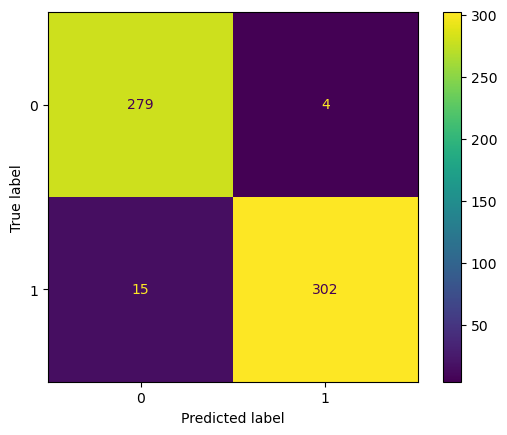

In [316]:
ConfusionMatrixDisplay.from_estimator(grid_model, X_test, y_test)

## Model based on text features

In [317]:
X = human_gpt[text_features]
y = human_gpt['label']

In [318]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [319]:
# Here I am declaring a parameter grid - what values I want to check while running the model.
param_grid = {'n_estimators':[90, 100, 110, 120], 'max_features':[2,3,4],'bootstrap':[True, False],
             'oob_score':[True, False]}

# Here I am creating an instance of our classifier
rfc = RandomForestClassifier()

# Here I am passing my classifier to a model that is going to check it with those various parameters 
# that I specified above
grid_model = GridSearchCV(rfc, param_grid=param_grid, cv=5)

In [ ]:
grid_model.fit(X_train, y_train)

### Feature importances of the text features model

In [321]:
features = X.columns
importances = grid_model.best_estimator_.feature_importances_

In [322]:
pd.DataFrame({'features': features, 'importances': importances})\
.sort_values(by='importances', ascending=False).reset_index(drop=True)

,features,importances
0,words_per_sent_std,0.236599
1,sentences_per_paragraph_mean,0.181344
2,sentences_per_paragraph_std,0.145060
3,words_per_paragraph_std,0.134787
4,words_per_paragraph_mean,0.117818
5,words_per_sent_mean,0.053247
6,sentence_count,0.048712
7,paragraph_count,0.048477
8,word_count,0.033956


### Final test scores for the text features model

In [323]:
# Time for some predictions
y_pred = grid_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       283
           1       0.94      0.93      0.94       317

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



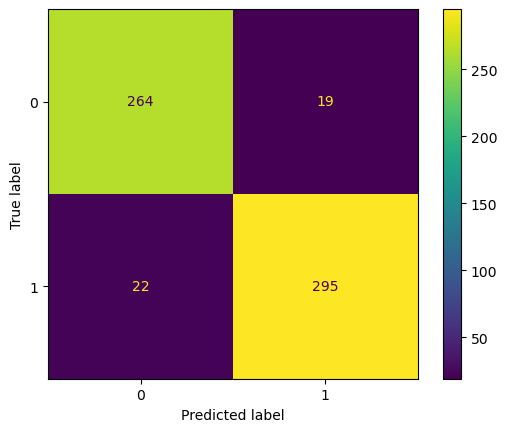

In [324]:
ConfusionMatrixDisplay.from_estimator(grid_model, X_test, y_test)

## Model based on stylistic features

In [325]:
X = human_gpt[stylistic_features]
y = human_gpt['label']

In [326]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [327]:
# Here I am declaring a parameter grid - what values I want to check while running the model.
param_grid = {'n_estimators':[90, 100, 110, 120], 'max_features':[2,3,4],'bootstrap':[True, False],
             'oob_score':[True, False]}

# Here I am creating an instance of our classifier
rfc = RandomForestClassifier()

# Here I am passing my classifier to a model that is going to check it with those various parameters 
# that I specified above
grid_model = GridSearchCV(rfc, param_grid=param_grid, cv=5)

In [ ]:
grid_model.fit(X_train, y_train)

### Feature importances of the stylistic features model

In [329]:
features = X.columns
importances = grid_model.best_estimator_.feature_importances_

In [330]:
pd.DataFrame({'features': features, 'importances': importances})\
.sort_values(by='importances', ascending=False).reset_index(drop=True)

,features,importances
0,reading_ease,0.200746
1,uniq_words_per_sent_std,0.162333
2,kincaid_grade,0.130688
3,uniq_word_count,0.073562
4,pronouns_count,0.058468
5,uniq_word_count_relative,0.057007
6,pos_tags_per_sentence_mean,0.055089
7,relative_pronouns_count,0.046999
8,uniq_words_per_sent_mean,0.046235
9,discourse_count,0.037594


### Final test scores for the stylistic features model

In [331]:
# Time for some predictions
y_pred = grid_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       283
           1       0.95      0.90      0.93       317

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.92       600
weighted avg       0.93      0.93      0.93       600



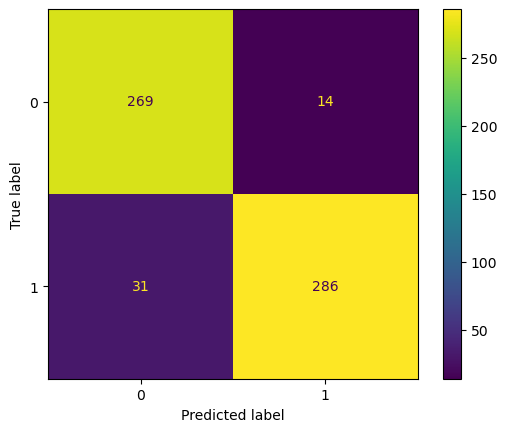

In [332]:
ConfusionMatrixDisplay.from_estimator(grid_model, X_test, y_test)

## Model based on punctuation

In [333]:
X = human_gpt[punctuation_features]
y = human_gpt['label']

In [334]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [336]:
# Here I am declaring a parameter grid - what values I want to check while running the model.
param_grid = {'n_estimators':[90, 100, 110, 120], 'max_features':[2,3,4],'bootstrap':[True, False],
             'oob_score':[True, False]}

# Here I am creating an instance of our classifier
rfc = RandomForestClassifier()

# Here I am passing my classifier to a model that is going to check it with those various parameters 
# that I specified above
grid_model = GridSearchCV(rfc, param_grid=param_grid, cv=5)

In [ ]:
grid_model.fit(X_train, y_train)

### Feature importances of the punctuation model

In [338]:
features = X.columns
importances = grid_model.best_estimator_.feature_importances_

In [339]:
pd.DataFrame({'features': features, 'importances': importances})\
.sort_values(by='importances', ascending=False).reset_index(drop=True)

,features,importances
0,punctuation_errors,0.837022
1,punctuation_count,0.162978


### Final test scores for the punctuation model

In [340]:
# Time for some predictions
y_pred = grid_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.65      0.73       283
           1       0.74      0.90      0.81       317

    accuracy                           0.78       600
   macro avg       0.79      0.77      0.77       600
weighted avg       0.79      0.78      0.77       600



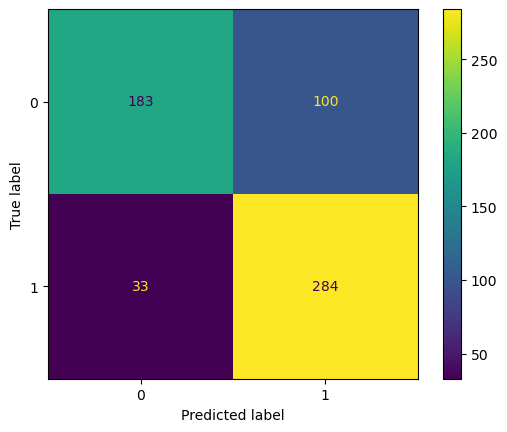

In [341]:
ConfusionMatrixDisplay.from_estimator(grid_model, X_test, y_test)